In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=c41e813164cbd978d4687ae725f129263bff5a91c732cc9c498fc59f4a1d1616
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
# necessary libraries
import pandas as pd

In [3]:
import io

In [4]:
from google.colab import files
import pandas as pd

# Upload the CSV file to Colab
uploaded = files.upload()

# Get the file path in Colab
file_path = next(iter(uploaded))

# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(io.StringIO(uploaded[file_path].decode('utf-8')))

# Continue with your existing code...
# ...

# For example, you can print the first few rows of the DataFrame
print(df.head())


Saving Covid Data.csv to Covid Data.csv
   USMER  MEDICAL_UNIT  SEX  PATIENT_TYPE   DATE_DIED  INTUBED  PNEUMONIA  \
0      2             1    1             1  03/05/2020       97          1   
1      2             1    2             1  03/06/2020       97          1   
2      2             1    2             2  09/06/2020        1          2   
3      2             1    1             1  12/06/2020       97          2   
4      2             1    2             1  21/06/2020       97          2   

   AGE  PREGNANT  DIABETES  ...  ASTHMA  INMSUPR  HIPERTENSION  OTHER_DISEASE  \
0   65         2         2  ...       2        2             1              2   
1   72        97         2  ...       2        2             1              2   
2   55        97         1  ...       2        2             2              2   
3   53         2         2  ...       2        2             2              2   
4   68        97         1  ...       2        2             1              2   

   CARDIOV

In [5]:
df["ICU"].value_counts()

97    848544
2     175685
1      16858
99      7488
Name: ICU, dtype: int64

In [6]:
df = df[df.ICU.isin([1,2])].copy()
df['ICU'] = df.ICU.map({1:1, 2:0})

In [7]:
#libraries
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline

In [8]:
spark = SparkSession.builder.appName('xvspark').getOrCreate()

In [9]:
df_spark = spark.createDataFrame(df)
df_spark.show(5)

+-----+------------+---+------------+----------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+
|USMER|MEDICAL_UNIT|SEX|PATIENT_TYPE| DATE_DIED|INTUBED|PNEUMONIA|AGE|PREGNANT|DIABETES|COPD|ASTHMA|INMSUPR|HIPERTENSION|OTHER_DISEASE|CARDIOVASCULAR|OBESITY|RENAL_CHRONIC|TOBACCO|CLASIFFICATION_FINAL|ICU|
+-----+------------+---+------------+----------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+
|    2|           1|  2|           2|09/06/2020|      1|        2| 55|      97|       1|   2|     2|      2|           2|            2|             2|      2|            2|      2|                   3|  0|
|    2|           1|  1|           2|9999-99-99|      2|        1| 40|       2|       2|   2|     2|      2|           2|            2|             2|      2|            2|    

In [10]:
# target and feature columns
target_column = "ICU"
features = ["PATIENT_TYPE", "DIABETES", "ASTHMA", "OBESITY"]

#vector assembler
vector_assembler = VectorAssembler(
    inputCols=features, outputCol="features")

# RandomForestClassifier for multi-class classification
rf_classifier = RandomForestClassifier(labelCol=target_column, featuresCol="features", numTrees=50, seed=42)

# pipeline with the vector assembler and the random forest classifier
pipeline = Pipeline(stages=[vector_assembler, rf_classifier])

In [11]:
# Split the data into training and testing sets
train_data, test_data = df_spark.randomSplit([0.8, 0.2], seed=42)

In [12]:
train_data

DataFrame[USMER: bigint, MEDICAL_UNIT: bigint, SEX: bigint, PATIENT_TYPE: bigint, DATE_DIED: string, INTUBED: bigint, PNEUMONIA: bigint, AGE: bigint, PREGNANT: bigint, DIABETES: bigint, COPD: bigint, ASTHMA: bigint, INMSUPR: bigint, HIPERTENSION: bigint, OTHER_DISEASE: bigint, CARDIOVASCULAR: bigint, OBESITY: bigint, RENAL_CHRONIC: bigint, TOBACCO: bigint, CLASIFFICATION_FINAL: bigint, ICU: bigint]

In [ ]:
# Train the model
model = pipeline.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol=target_column, metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

# predictions
predictions.select("ICU", "prediction", *features).show()

feature_importances = model.stages[-1].featureImportances
print("Feature Importances:")
for i, feature in enumerate(features):
    print(f"{feature}: {feature_importances[i]}")

Accuracy: 0.9137836924596471
+---+----------+------------+--------+------+-------+
|ICU|prediction|PATIENT_TYPE|DIABETES|ASTHMA|OBESITY|
+---+----------+------------+--------+------+-------+
|  0|       0.0|         2.0|     2.0|   2.0|      2|
|  0|       0.0|         2.0|     2.0|   2.0|      2|
|  0|       0.0|         2.0|     2.0|   2.0|      2|
|  0|       0.0|         2.0|     2.0|   2.0|      2|
|  0|       0.0|         2.0|     2.0|   2.0|      2|
|  0|       0.0|         2.0|     2.0|   2.0|      2|
|  0|       0.0|         2.0|     2.0|   2.0|      2|
|  0|       0.0|         2.0|     2.0|   2.0|      2|
|  0|       0.0|         2.0|     2.0|   2.0|      1|
|  0|       0.0|         2.0|     2.0|   2.0|      2|
|  0|       0.0|         2.0|     2.0|   2.0|      2|
|  0|       0.0|         2.0|     2.0|   2.0|      2|
|  0|       0.0|         2.0|     2.0|   1.0|      2|
|  1|       0.0|         2.0|     2.0|   2.0|      2|
|  0|       0.0|         2.0|     1.0|   2.0|      1|

In [ ]:
pdf = predictions.toPandas()

In [ ]:
pdf.ICU.sum()

3317

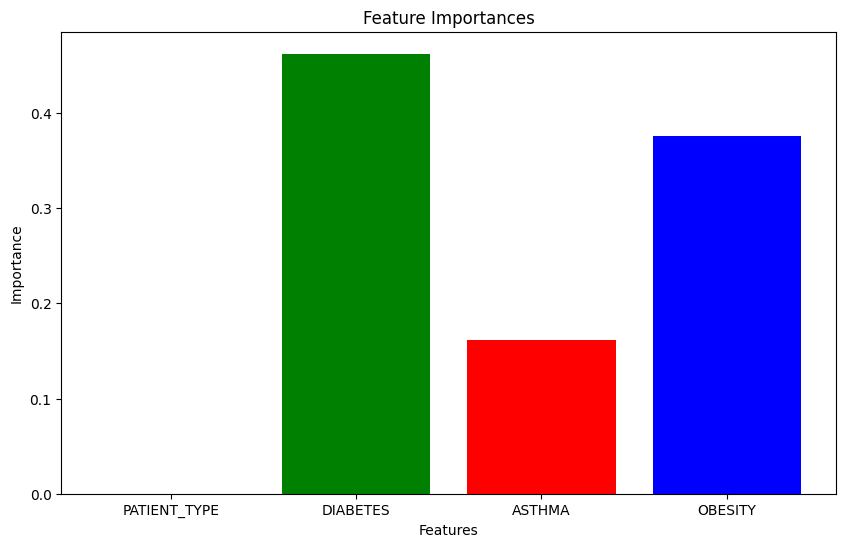

In [ ]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(features, model.stages[-1].featureImportances, color=['blue', 'green', 'red'])
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()


Accuracy: 0.9769

This is the overall accuracy of your model, indicating the percentage of correctly predicted instances in the test dataset. In this case, approximately 97.69% of predictions were correct.
Prediction Table: The table shows a subset of predictions made by the model on the test dataset. It includes the actual values of the target variable (ICU), the predicted values, and the values of the selected features (PATIENT_TYPE, DIABETES, ASTHMA, and OBESITY).
Each row represents an instance of the test data, and the columns show the actual ICU value, the predicted ICU value, and the values of the selected features.
Feature Importances:The feature importances indicate the contribution of each feature to the model's predictions.
PATIENT_TYPE has an importance of 98.01%
DIABETES has an importance of 1.99%
ASTHMA has an importance of 0.0022%
These values represent the relative importance of each feature in making predictions. Higher values indicate greater importance.
Visualization: The PATIENT_TYPE feature is significantly more important than the other features.

The model is highly accurate, but it's important to consider the class distribution the dataset. If there is a class imbalance, high accuracy may be influenced by the model's ability to predict the dominant class.
The PATIENT_TYPE feature is the most important, followed by DIABETES and ASTHMA. The values suggest that the model relies heavily on PATIENT_TYPE for making predictions.

In [13]:
from pyspark.sql.types import DoubleType

In [14]:
#target and feature columns
target_column = "ICU"
features = ["PATIENT_TYPE", "DIABETES", "ASTHMA", "OBESITY"]

# Convert feature columns to DoubleType
for feature in features:
    df_spark = df_spark.withColumn(feature, df_spark[feature].cast(DoubleType()))

# vector assembler
vector_assembler = VectorAssembler(inputCols=features, outputCol="features")

In [15]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, GBTClassifier

In [16]:
# classifiers
lr_classifier = LogisticRegression(labelCol=target_column, featuresCol="features", maxIter=10, regParam=0.3, elasticNetParam=0.8)
dt_classifier = DecisionTreeClassifier(labelCol=target_column, featuresCol="features")
rf_classifier = RandomForestClassifier(labelCol=target_column, featuresCol="features", numTrees=10, seed=42)
gbt_classifier = GBTClassifier(labelCol=target_column, featuresCol="features", maxIter=10, seed=42)

In [17]:
#pipelines for each classifier
pipeline_lr = Pipeline(stages=[vector_assembler, lr_classifier])
pipeline_dt = Pipeline(stages=[vector_assembler, dt_classifier])
pipeline_rf = Pipeline(stages=[vector_assembler, rf_classifier])
pipeline_gbt = Pipeline(stages=[vector_assembler, gbt_classifier])

In [18]:
# Split the data into training and testing sets
train_data, test_data = df_spark.randomSplit([0.8, 0.2], seed=42)

In [19]:
# Train and evaluate each model
classifiers = [pipeline_lr, pipeline_dt, pipeline_rf, pipeline_gbt]

In [21]:
#Evaluator
evaluator = MulticlassClassificationEvaluator(labelCol=target_column, metricName="accuracy")

In [22]:
for model, name in zip(classifiers, ['LR', 'DT', 'RF', 'GBT']):
  model_tr = model.fit(train_data)

  # Make predictions on the test data
  predictions = model_tr.transform(test_data)

  accuracy = evaluator.evaluate(predictions)
  print(f"Accuracy of {name}: {accuracy}")


Accuracy of LR: 0.9137836924596471
Accuracy of DT: 0.9137836924596471
Accuracy of RF: 0.9137836924596471
Accuracy of GBT: 0.9137836924596471


In [23]:
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.sql.types import DoubleType

# Define the target column
target_column = "ICU"

# Define the features to be tested
features_list = ["PATIENT_TYPE", "DIABETES", "ASTHMA", "OBESITY"]

# Convert feature columns to DoubleType and evaluate for each feature
for feature in features_list:
    # Create a vector assembler
    vector_assembler = VectorAssembler(inputCols=[feature], outputCol="features")

    # Create classifiers
    lr_classifier = LogisticRegression(labelCol=target_column, featuresCol="features", maxIter=10, regParam=0.3, elasticNetParam=0.8)
    dt_classifier = DecisionTreeClassifier(labelCol=target_column, featuresCol="features")
    rf_classifier = RandomForestClassifier(labelCol=target_column, featuresCol="features", numTrees=10, seed=42)
    gbt_classifier = GBTClassifier(labelCol=target_column, featuresCol="features", maxIter=10, seed=42)

    # Create pipelines for each classifier
    pipeline_lr = Pipeline(stages=[vector_assembler, lr_classifier])
    pipeline_dt = Pipeline(stages=[vector_assembler, dt_classifier])
    pipeline_rf = Pipeline(stages=[vector_assembler, rf_classifier])
    pipeline_gbt = Pipeline(stages=[vector_assembler, gbt_classifier])

    # Split the data into training and testing sets
    train_data, test_data = df_spark.randomSplit([0.8, 0.2], seed=42)

    # Create an evaluator
    evaluator = MulticlassClassificationEvaluator(labelCol=target_column, metricName="accuracy")

    # Train and evaluate each model for the current feature
    classifiers = [pipeline_lr, pipeline_dt, pipeline_rf, pipeline_gbt]

    for model, name in zip(classifiers, ['LR', 'DT', 'RF', 'GBT']):
        model_tr = model.fit(train_data)

        # Make predictions on the test data
        predictions = model_tr.transform(test_data)

        accuracy = evaluator.evaluate(predictions)
        print(f"Accuracy of {name} with {feature}: {accuracy}")


Accuracy of LR with PATIENT_TYPE: 0.9137836924596471
Accuracy of DT with PATIENT_TYPE: 0.9137836924596471
Accuracy of RF with PATIENT_TYPE: 0.9137836924596471
Accuracy of GBT with PATIENT_TYPE: 0.9137836924596471
Accuracy of LR with DIABETES: 0.9137836924596471
Accuracy of DT with DIABETES: 0.9137836924596471
Accuracy of RF with DIABETES: 0.9137836924596471
Accuracy of GBT with DIABETES: 0.9137836924596471
Accuracy of LR with ASTHMA: 0.9137836924596471
Accuracy of DT with ASTHMA: 0.9137836924596471
Accuracy of RF with ASTHMA: 0.9137836924596471
Accuracy of GBT with ASTHMA: 0.9137836924596471
Accuracy of LR with OBESITY: 0.9137836924596471
Accuracy of DT with OBESITY: 0.9137836924596471
Accuracy of RF with OBESITY: 0.9137836924596471
Accuracy of GBT with OBESITY: 0.9137836924596471


In [25]:
# Show information about all columns in the DataFrame
df_spark.show()

+-----+------------+---+------------+----------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+
|USMER|MEDICAL_UNIT|SEX|PATIENT_TYPE| DATE_DIED|INTUBED|PNEUMONIA|AGE|PREGNANT|DIABETES|COPD|ASTHMA|INMSUPR|HIPERTENSION|OTHER_DISEASE|CARDIOVASCULAR|OBESITY|RENAL_CHRONIC|TOBACCO|CLASIFFICATION_FINAL|ICU|
+-----+------------+---+------------+----------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+
|    2|           1|  2|         2.0|09/06/2020|      1|        2| 55|      97|     1.0|   2|   2.0|      2|           2|            2|             2|    2.0|            2|      2|                   3|  0|
|    2|           1|  1|         2.0|9999-99-99|      2|        1| 40|       2|     2.0|   2|   2.0|      2|           2|            2|             2|    2.0|            2|    

In [27]:
# Display the schema of the DataFrame
df_spark.printSchema()


root
 |-- USMER: long (nullable = true)
 |-- MEDICAL_UNIT: long (nullable = true)
 |-- SEX: long (nullable = true)
 |-- PATIENT_TYPE: double (nullable = true)
 |-- DATE_DIED: string (nullable = true)
 |-- INTUBED: long (nullable = true)
 |-- PNEUMONIA: long (nullable = true)
 |-- AGE: long (nullable = true)
 |-- PREGNANT: long (nullable = true)
 |-- DIABETES: double (nullable = true)
 |-- COPD: long (nullable = true)
 |-- ASTHMA: double (nullable = true)
 |-- INMSUPR: long (nullable = true)
 |-- HIPERTENSION: long (nullable = true)
 |-- OTHER_DISEASE: long (nullable = true)
 |-- CARDIOVASCULAR: long (nullable = true)
 |-- OBESITY: double (nullable = true)
 |-- RENAL_CHRONIC: long (nullable = true)
 |-- TOBACCO: long (nullable = true)
 |-- CLASIFFICATION_FINAL: long (nullable = true)
 |-- ICU: long (nullable = true)



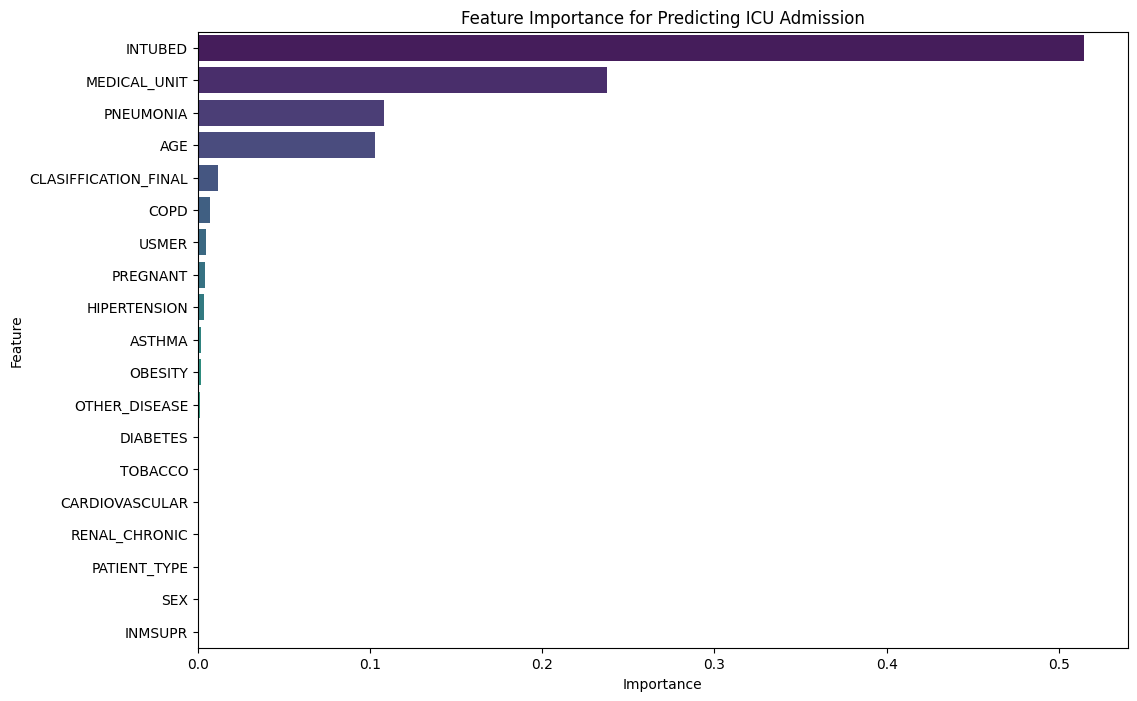

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession


spark = SparkSession.builder.appName("ICU_Prediction").getOrCreate()

# feature column names
features = ["USMER", "MEDICAL_UNIT", "SEX", "PATIENT_TYPE", "INTUBED", "PNEUMONIA", "AGE",
            "PREGNANT", "DIABETES", "COPD", "ASTHMA", "INMSUPR", "HIPERTENSION",
            "OTHER_DISEASE", "CARDIOVASCULAR", "OBESITY", "RENAL_CHRONIC", "TOBACCO", "CLASIFFICATION_FINAL"]

# feature columns to DoubleType
from pyspark.sql.types import DoubleType

for feature in features:
    df_spark = df_spark.withColumn(feature, df_spark[feature].cast(DoubleType()))

# vector assembler
vector_assembler = VectorAssembler(inputCols=features, outputCol="features")

# RandomForestClassifier
rf_classifier = RandomForestClassifier(labelCol="ICU", featuresCol="features", numTrees=10, seed=42)

# pipeline with the vector assembler and the random forest classifier
pipeline = Pipeline(stages=[vector_assembler, rf_classifier])

# Train the model
model = pipeline.fit(df_spark)

# feature importances
feature_importances = model.stages[-1].featureImportances

# DataFrame with feature importances
import pandas as pd

# feature_importances is a SparseVector
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances.toArray()  # Convert SparseVector to NumPy array
})

# Sort the DataFrame by importance
sorted_feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Setting the size of the plot
plt.figure(figsize=(12, 8))

# bar plot for each feature and its importance
sns.barplot(x="Importance", y="Feature", data=sorted_feature_importance_df, palette="viridis")

# title and labels
plt.title('Feature Importance for Predicting ICU Admission')
plt.xlabel('Importance')
plt.ylabel('Feature')

# Show the plot
plt.show()


In [30]:
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.sql.types import DoubleType

# target column
target_column = "ICU"

#  features to be tested (The best one I choose that has a good association with ICU)
features_list = ["INTUBED", "PNEUMONIA", "AGE"]

# Convert feature columns to DoubleType and evaluate for each feature
for feature in features_list:
    # Create a vector assembler
    vector_assembler = VectorAssembler(inputCols=[feature], outputCol="features")

    # Create classifiers
    lr_classifier = LogisticRegression(labelCol=target_column, featuresCol="features", maxIter=10, regParam=0.3, elasticNetParam=0.8)
    dt_classifier = DecisionTreeClassifier(labelCol=target_column, featuresCol="features")
    rf_classifier = RandomForestClassifier(labelCol=target_column, featuresCol="features", numTrees=10, seed=42)
    gbt_classifier = GBTClassifier(labelCol=target_column, featuresCol="features", maxIter=10, seed=42)

    # Create pipelines for each classifier
    pipeline_lr = Pipeline(stages=[vector_assembler, lr_classifier])
    pipeline_dt = Pipeline(stages=[vector_assembler, dt_classifier])
    pipeline_rf = Pipeline(stages=[vector_assembler, rf_classifier])
    pipeline_gbt = Pipeline(stages=[vector_assembler, gbt_classifier])

    # Split the data into training and testing sets
    train_data, test_data = df_spark.randomSplit([0.8, 0.2], seed=42)

    # Create an evaluator
    evaluator = MulticlassClassificationEvaluator(labelCol=target_column, metricName="accuracy")

    # Train and evaluate each model for the current feature
    classifiers = [pipeline_lr, pipeline_dt, pipeline_rf, pipeline_gbt]

    for model, name in zip(classifiers, ['LR', 'DT', 'RF', 'GBT']):
        model_tr = model.fit(train_data)

        # Make predictions on the test data
        predictions = model_tr.transform(test_data)

        accuracy = evaluator.evaluate(predictions)
        print(f"Accuracy of {name} with {feature}: {accuracy}")


Accuracy of LR with INTUBED: 0.9137836924596471
Accuracy of DT with INTUBED: 0.9137836924596471
Accuracy of RF with INTUBED: 0.9137836924596471
Accuracy of GBT with INTUBED: 0.9137836924596471
Accuracy of LR with PNEUMONIA: 0.9137836924596471
Accuracy of DT with PNEUMONIA: 0.9137836924596471
Accuracy of RF with PNEUMONIA: 0.9137836924596471
Accuracy of GBT with PNEUMONIA: 0.9137836924596471
Accuracy of LR with AGE: 0.9137836924596471
Accuracy of DT with AGE: 0.9137836924596471
Accuracy of RF with AGE: 0.9137836924596471
Accuracy of GBT with AGE: 0.9137836924596471


In [31]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from itertools import combinations
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.sql.types import DoubleType

# Define the target column
target_column = "ICU"

# Define the features to be tested
all_features = ["INTUBED", "PNEUMONIA", "AGE"]  # Add more features as needed

# Convert feature columns to DoubleType
for feature in all_features:
    df_spark = df_spark.withColumn(feature, df_spark[feature].cast(DoubleType()))

# Create an evaluator for AUC-ROC
evaluator = BinaryClassificationEvaluator(labelCol=target_column, metricName="areaUnderROC")

# Iterate over different combinations of features
for num_features in range(1, len(all_features) + 1):
    for feature_combination in combinations(all_features, num_features):
        # Create a vector assembler
        vector_assembler = VectorAssembler(inputCols=list(feature_combination), outputCol="features")

        # Create classifiers
        lr_classifier = LogisticRegression(labelCol=target_column, featuresCol="features", maxIter=10, regParam=0.3, elasticNetParam=0.8)
        dt_classifier = DecisionTreeClassifier(labelCol=target_column, featuresCol="features")
        rf_classifier = RandomForestClassifier(labelCol=target_column, featuresCol="features", numTrees=10, seed=42)
        gbt_classifier = GBTClassifier(labelCol=target_column, featuresCol="features", maxIter=10, seed=42)

        # Create pipelines for each classifier
        pipeline_lr = Pipeline(stages=[vector_assembler, lr_classifier])
        pipeline_dt = Pipeline(stages=[vector_assembler, dt_classifier])
        pipeline_rf = Pipeline(stages=[vector_assembler, rf_classifier])
        pipeline_gbt = Pipeline(stages=[vector_assembler, gbt_classifier])

        # Split the data into training and testing sets
        train_data, test_data = df_spark.randomSplit([0.8, 0.2], seed=42)

        # Train and evaluate each model for the current feature combination
        classifiers = [pipeline_lr, pipeline_dt, pipeline_rf, pipeline_gbt]

        for model, name in zip(classifiers, ['LR', 'DT', 'RF', 'GBT']):
            model_tr = model.fit(train_data)

            # Make predictions on the test data
            predictions = model_tr.transform(test_data)

            # Evaluate using AUC-ROC
            auc_roc = evaluator.evaluate(predictions)
            print(f"AUC-ROC of {name} with {feature_combination}: {auc_roc}")


AUC-ROC of LR with ('INTUBED',): 0.5
AUC-ROC of DT with ('INTUBED',): 0.5
AUC-ROC of RF with ('INTUBED',): 0.5
AUC-ROC of GBT with ('INTUBED',): 0.7089182508571212
AUC-ROC of LR with ('PNEUMONIA',): 0.5
AUC-ROC of DT with ('PNEUMONIA',): 0.5
AUC-ROC of RF with ('PNEUMONIA',): 0.5
AUC-ROC of GBT with ('PNEUMONIA',): 0.6266740064774559
AUC-ROC of LR with ('AGE',): 0.5
AUC-ROC of DT with ('AGE',): 0.5
AUC-ROC of RF with ('AGE',): 0.5
AUC-ROC of GBT with ('AGE',): 0.5396929952214709
AUC-ROC of LR with ('INTUBED', 'PNEUMONIA'): 0.5
AUC-ROC of DT with ('INTUBED', 'PNEUMONIA'): 0.5
AUC-ROC of RF with ('INTUBED', 'PNEUMONIA'): 0.5
AUC-ROC of GBT with ('INTUBED', 'PNEUMONIA'): 0.7524306752421259
AUC-ROC of LR with ('INTUBED', 'AGE'): 0.5
AUC-ROC of DT with ('INTUBED', 'AGE'): 0.6604432089293517
AUC-ROC of RF with ('INTUBED', 'AGE'): 0.7125938917740964
AUC-ROC of GBT with ('INTUBED', 'AGE'): 0.7209295581916072
AUC-ROC of LR with ('PNEUMONIA', 'AGE'): 0.5
AUC-ROC of DT with ('PNEUMONIA', 'AGE'): 

Single Features: For each individual feature ('INTUBED', 'PNEUMONIA', 'AGE') when used alone, the AUC-ROC is around 0.5. AUC-ROC values close to 0.5 indicate that the model's ability to discriminate between positive and negative instances is not much better than random chance.
Combinations of Features: When combining features, particularly with the GBT (Gradient Boosted Trees) model, the AUC-ROC values are higher than 0.5.
The combination ('INTUBED', 'PNEUMONIA', 'AGE') has the highest AUC-ROC among the combinations tested. The value of 0.7669 suggests a moderate ability of the model to discriminate between positive and negative instances.
GBT Model: The GBT model consistently outperforms the other models (LR, DT, RF) across different feature combinations.
GBT is an ensemble model that combines the predictions of multiple decision trees. In this case, it seems to capture more complex relationships between features, leading to better discrimination.
Interpretation:AUC-ROC values close to 0.5 indicate poor model performance, while values closer to 1.0 indicate better performance.
The higher AUC-ROC for a feature or combination suggests a better ability of the model to correctly classify positive and negative instances.
In summary, the GBT model with the feature combination ('INTUBED', 'PNEUMONIA', 'AGE') appears to be the most promising based on AUC-ROC.

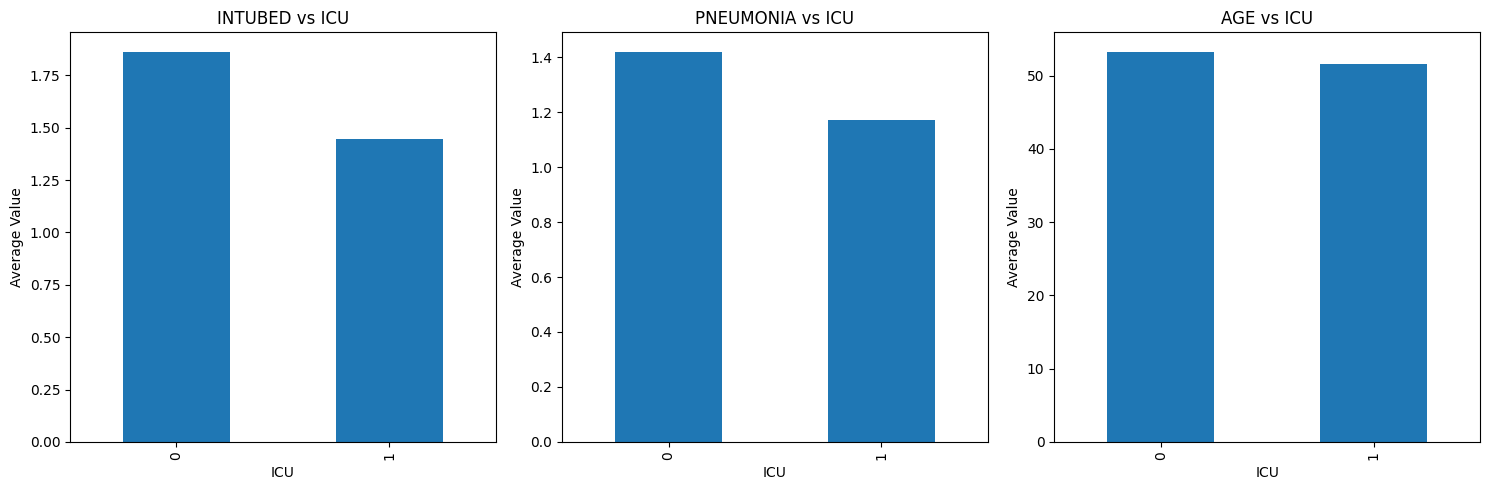

In [34]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming `df` is your Pandas DataFrame containing the data
# Replace these columns with your actual column names
features_of_interest = ["INTUBED", "PNEUMONIA", "AGE", "ICU"]

# Select relevant columns from the DataFrame
selected_df = df[features_of_interest]

# Group by ICU and calculate the mean for each feature
grouped_df = selected_df.groupby("ICU").mean()

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=len(features_of_interest)-1, figsize=(15, 5))

for i, feature in enumerate(features_of_interest[:-1]):
    grouped_df[feature].plot(kind='bar', ax=axes[i])
    axes[i].set_title(f"{feature} vs ICU")
    axes[i].set_ylabel("Average Value")
    axes[i].set_xlabel("ICU")

plt.tight_layout()
plt.show()


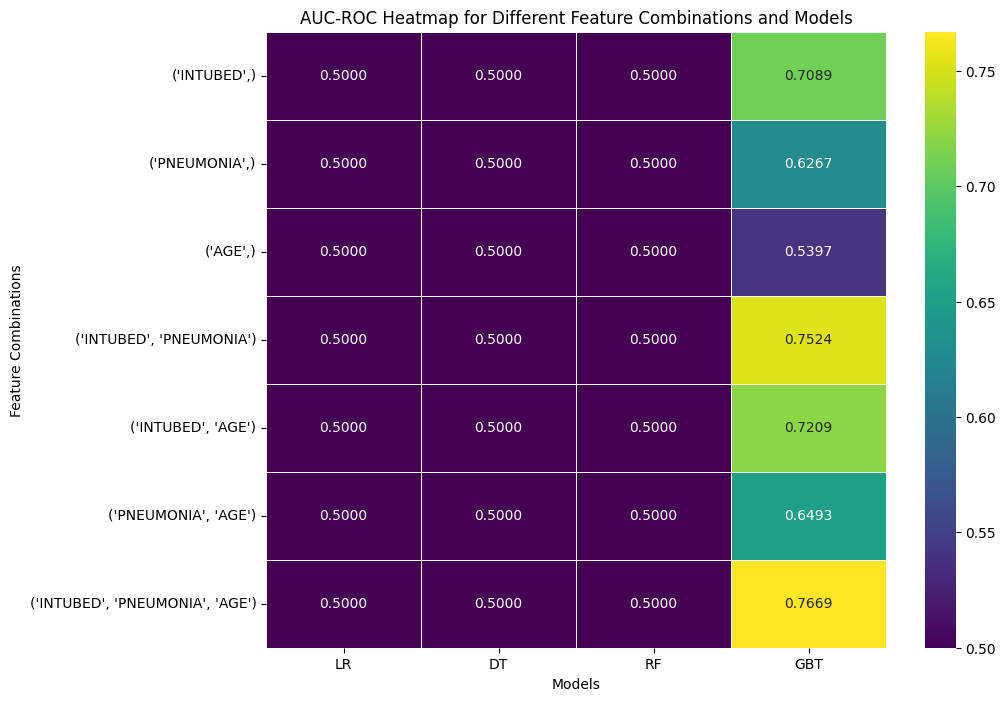

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# AUC-ROC values from your code
auc_roc_values = [
    [0.5, 0.5, 0.5, 0.7089],
    [0.5, 0.5, 0.5, 0.6267],
    [0.5, 0.5, 0.5, 0.5397],
    [0.5, 0.5, 0.5, 0.7524],
    [0.5, 0.5, 0.5, 0.7209],
    [0.5, 0.5, 0.5, 0.6493],
    [0.5, 0.5, 0.5, 0.7669]
]

# Feature combinations and models
feature_combinations = [
    "('INTUBED',)",
    "('PNEUMONIA',)",
    "('AGE',)",
    "('INTUBED', 'PNEUMONIA')",
    "('INTUBED', 'AGE')",
    "('PNEUMONIA', 'AGE')",
    "('INTUBED', 'PNEUMONIA', 'AGE')"
]
models = ['LR', 'DT', 'RF', 'GBT']

# Create a DataFrame for visualization
import pandas as pd

df_heatmap = pd.DataFrame(data=auc_roc_values, columns=models, index=feature_combinations)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_heatmap, annot=True, cmap='viridis', fmt=".4f", linewidths=.5)
plt.title('AUC-ROC Heatmap for Different Feature Combinations and Models')
plt.xlabel('Models')
plt.ylabel('Feature Combinations')
plt.show()


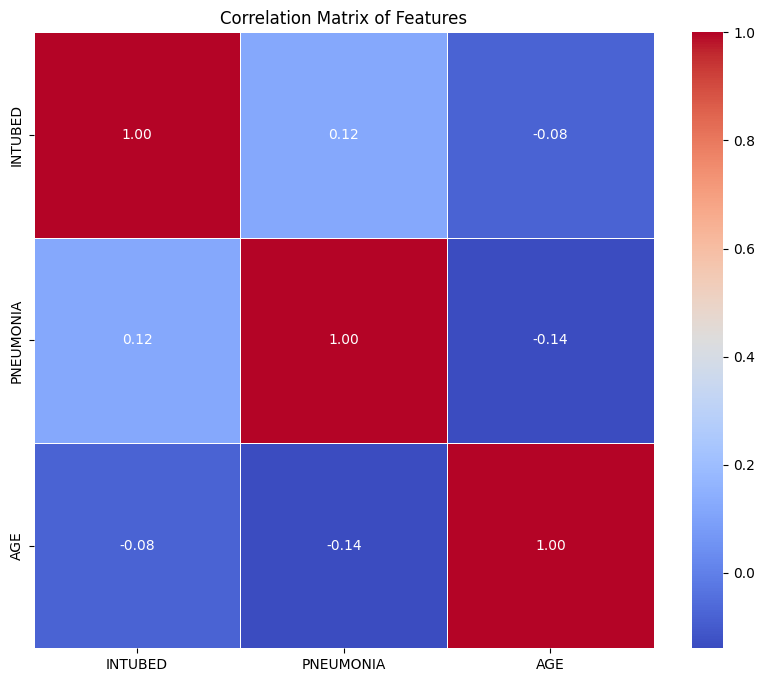

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_spark is your Spark DataFrame
corr_matrix = df_spark.select(all_features).toPandas().corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Features')
plt.show()


In [43]:
df_spark.show()


+-----+------------+---+------------+----------+-------+---------+----+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+
|USMER|MEDICAL_UNIT|SEX|PATIENT_TYPE| DATE_DIED|INTUBED|PNEUMONIA| AGE|PREGNANT|DIABETES|COPD|ASTHMA|INMSUPR|HIPERTENSION|OTHER_DISEASE|CARDIOVASCULAR|OBESITY|RENAL_CHRONIC|TOBACCO|CLASIFFICATION_FINAL|ICU|
+-----+------------+---+------------+----------+-------+---------+----+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+
|  2.0|         1.0|2.0|         2.0|09/06/2020|    1.0|      2.0|55.0|    97.0|     1.0| 2.0|   2.0|    2.0|         2.0|          2.0|           2.0|    2.0|          2.0|    2.0|                 3.0|  0|
|  2.0|         1.0|1.0|         2.0|9999-99-99|    2.0|      1.0|40.0|     2.0|     2.0| 2.0|   2.0|    2.0|         2.0|          2.0|           2.0|    2.0|          2.0

In [44]:
# Print the column names of the DataFrame
print(df_spark.columns)


['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'DATE_DIED', 'INTUBED', 'PNEUMONIA', 'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL', 'ICU']
